In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.feature_selection import RFECV
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('vehicles.csv')

In [3]:
df.shape

(435849, 25)

## Data Cleaning

In [4]:
# Removing rows with missing price and year
df.drop(df[df['price'] == 0].index, inplace = True) 
df.drop(df[df['year'].isna()].index, inplace = True) 
df.drop(df[df['year'] == 2021].index, inplace = True)
df.drop([496], inplace = True)
df.drop(df[df.odometer > 500000].index, inplace = True)

In [5]:
# Changing type of year to int
df['year'] = df['year'].astype(int)
df['year'].dtype

dtype('int64')

In [6]:
year_med =  dict(df.groupby('year')['odometer'].median())

In [7]:
# Imputing missing values in odometer with median odometer of each year cars
df['odometer'] = df['odometer'].fillna(df['year'].apply(lambda x: year_med.get(x)))

In [8]:
# Removing the leftover missing values in odometer because no information available for those years
df.drop(df[df['odometer'].isna()].index, inplace = True) 

In [9]:
df.shape

(402995, 25)

In [10]:
# Dropping cars with price less than 1000 with miles less than 60,000 and model year greater than 2010
df.drop(df[(df.price < 1000 ) & (df.odometer < 60000 ) & (df.year > 2010)].index, inplace = True)
df.drop(df[(df.price < 200)].index, inplace = True)
df.drop(df[(df.price > 50000)].index, inplace = True)

In [11]:
df.shape

(391442, 25)

In [12]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7119256118,https://mohave.craigslist.org/ctd/d/lake-havas...,mohave county,https://mohave.craigslist.org,3495,2012,jeep,patriot,like new,4 cylinders,gas,104259.0,clean,automatic,NaN,NaN,NaN,NaN,silver,https://images.craigslist.org/00B0B_k2AXIJ21ok...,"THIS 2012 JEEP PATRIOT IS A 4CYL. AC, STEREO, ...",NaN,az,34.4554,-114.2690
1,7120880186,https://oregoncoast.craigslist.org/cto/d/warre...,oregon coast,https://oregoncoast.craigslist.org,13750,2014,bmw,328i m-sport,good,NaN,gas,76237.0,clean,automatic,NaN,rwd,NaN,sedan,grey,https://images.craigslist.org/00U0U_3cLk0WGOJ8...,Selling my 2014 BMW 328i with the following be...,NaN,or,46.1837,-123.8240
2,7115048251,https://greenville.craigslist.org/cto/d/sparta...,greenville / upstate,https://greenville.craigslist.org,2300,2001,dodge,caravan,excellent,6 cylinders,gas,199000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/00k0k_t4WqYn5nDC...,"01 DODGE CARAVAN,3.3 ENGINE,AUT TRANS,199000 M...",NaN,sc,34.9352,-81.9654
3,7119250502,https://mohave.craigslist.org/cto/d/lake-havas...,mohave county,https://mohave.craigslist.org,9000,2004,chevrolet,colorado ls,excellent,5 cylinders,gas,54000.0,clean,automatic,1GCCS196448191644,rwd,mid-size,pickup,red,https://images.craigslist.org/00J0J_lJEzfeVLHI...,"2004 Chevy Colorado LS, ONLY 54000 ORIGINAL MI...",NaN,az,34.4783,-114.2710
5,7120432569,https://maine.craigslist.org/ctd/d/bad-credit-...,maine,https://maine.craigslist.org,500,2010,NaN,$500 DOWN PROGRAMS!!!,NaN,NaN,gas,120757.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/01010_7qTZ8KZK03...,☛WE have 100's OF VEHICLES to choose from! CAL...,NaN,me,42.8424,-71.1077


In [13]:
# Dropping rows with missing cylinders, transmission and drive
df.drop(df[(df['cylinders'].isna()) & (df['transmission'].isna()) & (df['drive'].isna())].index, inplace = True)

In [14]:
df['cylinders'] = df['cylinders'].apply(lambda x: x[0] if not pd.isnull(x) else np.nan)

In [15]:
# Changing cylinders of tesla cars to 0
df.loc[df.manufacturer == 'tesla', 'cylinders'] = 0
df.cylinders.fillna(0, inplace = True)
df.cylinders =  df.cylinders.replace('o', 0)

In [16]:
df['cylinders'] = df['cylinders'].astype(int)


In [17]:
# Changing cylinder of all 2019 honda accords to 4
df.loc[((df.manufacturer == 'honda') & (df.year == 2019) & (df.model == 'accord')), 'cylinders'] = 4

In [18]:
df.loc[((df.manufacturer == 'honda') & (df.year == 2020) & (df.model == 'accord')),'cylinders'] = 4

In [19]:
# Dropping unwanted columns
df.drop(['id', 'url', 'region_url', 'vin', 'county', 'lat', 'long','image_url', 'region'], axis = 1, inplace = True) 

In [20]:
df.shape

(390671, 16)

In [21]:
df.isna().sum()

price                0
year                 0
manufacturer     15695
model             5492
condition       157235
cylinders            0
fuel              2158
odometer             0
title_status      1130
transmission      1043
drive           106431
size            263842
type            104388
paint_color     117768
description          2
state                0
dtype: int64

In [22]:
# filling missing condition values with fair considering their condition would be fair
df.condition.fillna('fair', inplace = True)

In [23]:
df.condition.replace('like new', 'excellent', inplace = True)
df.condition.replace('new', 'excellent', inplace = True)

In [24]:
df.condition.value_counts()

fair         164011
excellent    135595
good          90407
salvage         658
Name: condition, dtype: int64

In [25]:
df.fuel.fillna('gas', inplace = True)

In [26]:
df.fuel.value_counts()

gas         343691
diesel       31700
other        10556
hybrid        3889
electric       835
Name: fuel, dtype: int64

In [27]:
df.transmission.value_counts()

automatic    347340
manual        26441
other         15847
Name: transmission, dtype: int64

In [28]:
df.loc[(df['description'].str.contains('automatic transmission')) & (df['transmission'] == 'other'), "transmission"] = "automatic"
df.loc[(df['description'].str.contains('manual transmission')) & (df['transmission'] == 'other'), "transmission"] = "manual"
df.loc[(df['description'].str.contains('automatic transmission')) & (df['transmission'].isna()), "transmission"] = "automatic"
df.loc[(df['description'].str.contains('manual transmission')) & (df['transmission'].isna()), "transmission"] = "manual"

df.loc[(df['description'].str.contains('Automatic Transmission')) & (df['transmission'] == 'other'), "transmission"] = "automatic"
df.loc[(df['description'].str.contains('Manual Transmission')) & (df['transmission'] == 'other'), "transmission"] = "manual"
df.loc[(df['description'].str.contains('Automatic Transmission')) & (df['transmission'].isna()), "transmission"] = "automatic"
df.loc[(df['description'].str.contains('Manual Transmission')) & (df['transmission'].isna()), "transmission"] = "manual"

df.loc[(df['description'].str.contains('AUTOMATIC TRANSMISSION')) & (df['transmission'] == 'other'), "transmission"] = "automatic"
df.loc[(df['description'].str.contains('MANUAL TRANSMISSION')) & (df['transmission'] == 'other'), "transmission"] = "manual"
df.loc[(df['description'].str.contains('AUTOMATIC TRANSMISSION')) & (df['transmission'].isna()), "transmission"] = "automatic"
df.loc[(df['description'].str.contains('MANUAL TRANSMISSION')) & (df['transmission'].isna()), "transmission"] = "manual"


In [29]:
# Assuming most cars have automatic transmission
df.transmission.fillna('automatic', inplace = True)

In [30]:
df.isna().mean()

price           0.000000
year            0.000000
manufacturer    0.040174
model           0.014058
condition       0.000000
cylinders       0.000000
fuel            0.000000
odometer        0.000000
title_status    0.002892
transmission    0.000000
drive           0.272431
size            0.675356
type            0.267202
paint_color     0.301451
description     0.000005
state           0.000000
dtype: float64

### Dummy Regression

In [31]:
df.columns

Index(['price', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'description', 'state'],
      dtype='object')

In [32]:
features = ['year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'state']

target = df['price']

In [33]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(df[features], target)
dummy_regr.predict(df[features])


array([13389.78691021, 13389.78691021, 13389.78691021, ...,
       13389.78691021, 13389.78691021, 13389.78691021])

In [34]:
df.price.mean()

13389.786910213454

### Hypothesis Tests

#### First Hypothesis test

In [35]:
# Null Hypothesis: There is no significant relation between price and odometer of a car
# Alt-Hypothesis: There is a significant relation between price and odometer.

print(stats.ttest_ind(df['price'], df['odometer']))

# Ttest_indResult(statistic=-540.8668108166449, pvalue=0.0)

# Reject Null Hypthesis
# p-value << 0.05 
# There is a significant relation between price and odometer



Ttest_indResult(statistic=-932.7983792391728, pvalue=0.0)


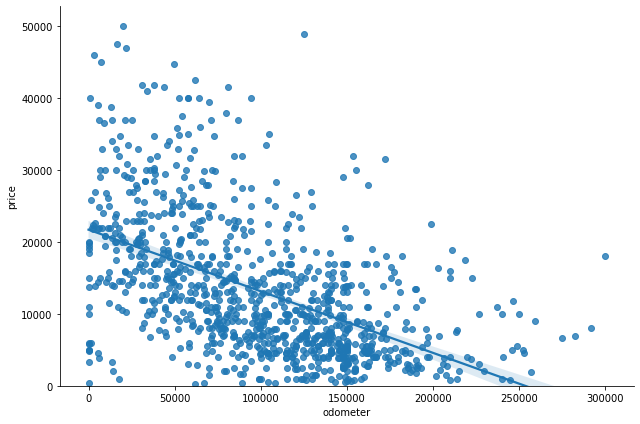

In [36]:
# Using sample because 
sample = df.sample(n = 1000)
sns.lmplot('odometer', 'price', data=sample[['price','odometer']],height = 6, aspect = 1.5)
plt.ylim(0, None);

#### Second Hypothesis test

In [37]:
# Null Hypothesis: There is no significant relation between price and year of a car
# Alt-Hypothesis: There is a significant relation between price and year.

print(stats.ttest_ind(df['price'], df['year']))

# Ttest_indResult(statistic=736.1846690665705, pvalue=0.0)

# Reject Null Hypthesis
# p-value << 0.05 
# There is a significant relation between price and year

Ttest_indResult(statistic=735.5931976838725, pvalue=0.0)


(0, 53765.91361727511)

<Figure size 1080x576 with 0 Axes>

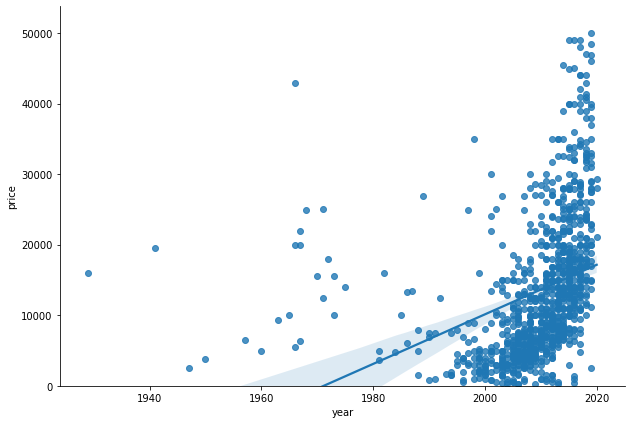

In [38]:
sample = df.sample(n = 1000)
plt.figure(figsize=(15,8))
sns.lmplot('year', 'price', data=sample[['price','year']] ,height = 6, aspect = 1.5)
plt.ylim(0, None)



#### Third Hypthesis test

In [39]:
# Null Hypothesis: There is no significant relation between price and title_status of a car
# Alt-Hypothesis: There is a significant relation between price and title_status.


anova = ols('price~title_status', data=df).fit()
anova_table = sm.stats.anova_lm(anova, type=2)
print(anova_table)

# p-value = 0
# F-stat = 664.687937
# Reject Null Hypothesis
# There is a significant relation between price and title_status.

                    df        sum_sq       mean_sq           F  PR(>F)
title_status       5.0  3.080862e+11  6.161725e+10  664.687937     0.0
Residual      389535.0  3.611029e+13  9.270102e+07         NaN     NaN


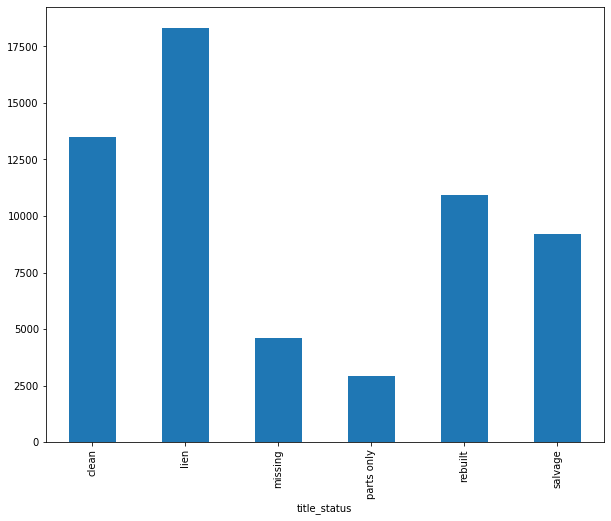

In [40]:
plt.figure(figsize=(10,8))
df.groupby('title_status').price.mean().plot(kind = 'bar')

### Visualizations

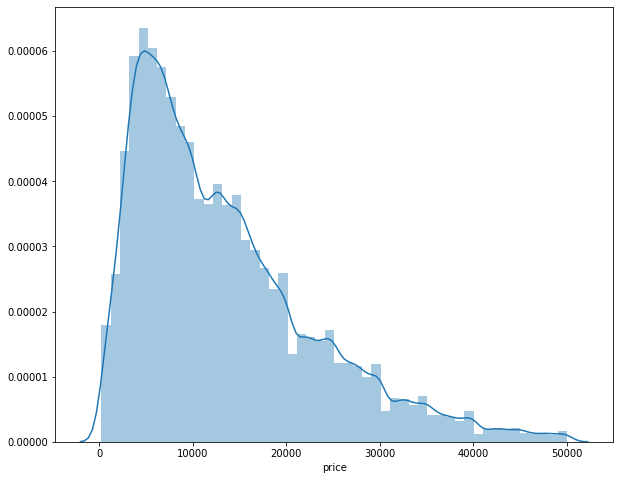

In [41]:
plt.figure(figsize=(10,8))
sns.distplot(df.price)

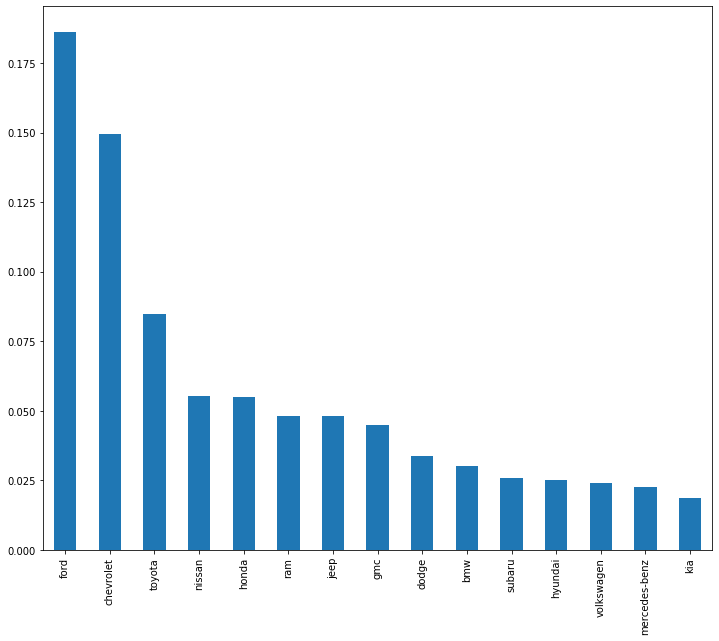

In [42]:
plt.figure(figsize=(12,10))
df['manufacturer'].value_counts(normalize = True).head(15).plot(kind='bar')

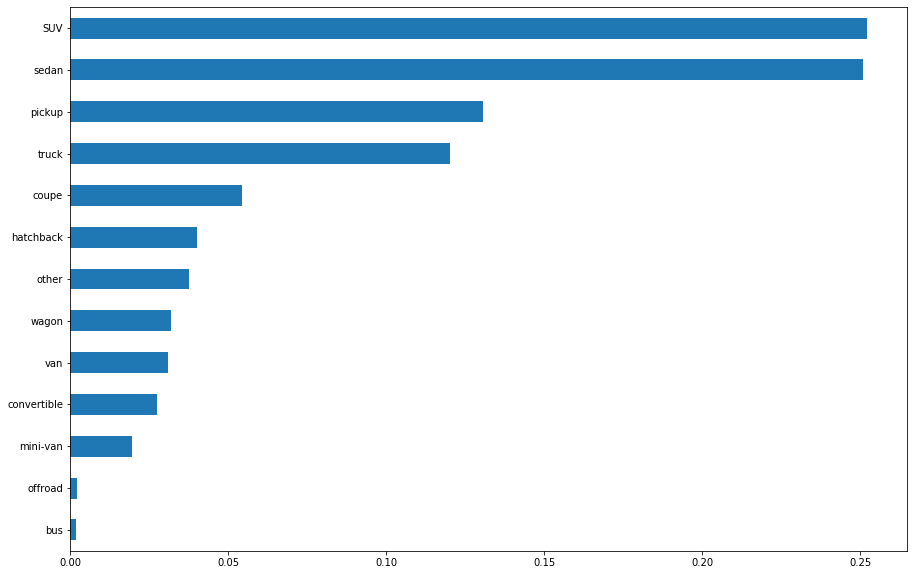

In [43]:
plt.figure(figsize=(15,10))
df['type'].value_counts(normalize = True, ascending = True).plot(kind='barh')

##  Creating New Columns from Description


In [44]:
df.shape

(390671, 16)

In [45]:
# Going through description to check how many cars have new tires and creating a column for new tires
df['new_tires'] = np.where((df['description'].str.contains('new tire')) |
                           (df['description'].str.contains('NEW TIRE')) |
                           (df['description'].str.contains('New Tire')) |
                           (df['description'].str.contains('new TIRE')) |
                           (df['description'].str.contains('NEW tire')), 1,0) 

In [46]:
df['new_tires'].sum()

23698

In [47]:
df['heated_seats'] = np.where((df['description'].str.contains('HEATED SEAT')) |
                           (df['description'].str.contains('heated seat')) |
                           (df['description'].str.contains('Heated Seat')) |
                           (df['description'].str.contains('heated SEAT')) |
                           (df['description'].str.contains('HEATED seat')), 1,0)

In [48]:
df['heated_seats'].sum()

36540

In [49]:
df['auto_headlight'] = np.where((df['description'].str.contains('automatic headlight')) |
                                (df['description'].str.contains('auto headlight')) |
                                (df['description'].str.contains('AUTOMATIC HEADLIGHT')) |
                                (df['description'].str.contains('Automatic Headlight')) |
                                (df['description'].str.contains('AUTO HEADLIGHT')) |
                                (df['description'].str.contains('Auto Headlight')), 1,0)

In [50]:
df['auto_headlight'].sum()

20733

In [51]:
# Creating a power_steering column, going through description to check for word power steering
# Also assuming almost all cars after 2000 have power steering
df['power steering'] = np.where((df['description'].str.contains('power steering')) |
                                (df['description'].str.contains('POWER STEERING')) |
                                (df['year'] > 2000), 1,0)

In [52]:
df['power steering'].sum()

360560

In [53]:
df['leather'] = np.where((df['description'].str.contains('leather')) |
                          (df['description'].str.contains('Leather'))|
                          (df['description'].str.contains('LEATHER')) , 1,0)

In [54]:
df['leather'].sum()

108343

In [55]:
# Removing Description and model column
df.drop(['description', 'model','state'], axis = 1, inplace = True)


In [56]:
df.columns

Index(['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'size', 'type',
       'paint_color', 'new_tires', 'heated_seats', 'auto_headlight',
       'power steering', 'leather'],
      dtype='object')

### Checking Collinearity

In [57]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,price,year,cylinders,odometer,new_tires,heated_seats,auto_headlight,power steering,leather
price,NaN,0.320478,0.038297,0.485847,0.055351,0.130898,0.091417,0.150351,0.156229
year,NaN,NaN,0.112921,0.256565,0.036123,0.105427,0.104295,0.702086,0.119360
cylinders,NaN,NaN,NaN,0.109450,0.036414,0.033701,0.016327,0.063050,0.060908
odometer,NaN,NaN,NaN,NaN,0.047317,0.062010,0.084482,0.079610,0.043220
new_tires,NaN,NaN,NaN,NaN,NaN,0.018874,0.024044,0.015418,0.017939
heated_seats,NaN,NaN,NaN,NaN,NaN,NaN,0.108578,0.082873,0.345557
auto_headlight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.065673,0.196910
power steering,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.112797
leather,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)

[]


## Creating Dummy Variables

In [59]:
df.columns

Index(['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'size', 'type',
       'paint_color', 'new_tires', 'heated_seats', 'auto_headlight',
       'power steering', 'leather'],
      dtype='object')

In [60]:
dff = df
target = df['price']
df =  pd.get_dummies(df, columns=['manufacturer'], drop_first = True )
df =  pd.get_dummies(df, columns=['condition'], drop_first = True )
df =  pd.get_dummies(df, columns=['fuel'], drop_first = True )
df =  pd.get_dummies(df, columns=['title_status'], drop_first = True )
df =  pd.get_dummies(df, columns=['transmission'], drop_first = True )
df =  pd.get_dummies(df, columns=['drive'], drop_first = True )
df =  pd.get_dummies(df, columns=['size'], drop_first = True )
df =  pd.get_dummies(df, columns=['type'], drop_first = True )
df =  pd.get_dummies(df, columns=['paint_color'], drop_first = True )
#df =  pd.get_dummies(df, columns=['state'], drop_first = True )
#df =  pd.get_dummies(df, columns=['cylinders'], drop_first = True )

In [61]:
df.head()

,price,year,cylinders,odometer,new_tires,heated_seats,auto_headlight,power steering,leather,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_datsun,manufacturer_dodge,manufacturer_ferrari,manufacturer_fiat,manufacturer_ford,manufacturer_gmc,manufacturer_harley-davidson,manufacturer_honda,manufacturer_hyundai,manufacturer_infiniti,manufacturer_jaguar,manufacturer_jeep,manufacturer_kia,manufacturer_land rover,manufacturer_lexus,manufacturer_lincoln,manufacturer_mazda,manufacturer_mercedes-benz,manufacturer_mercury,manufacturer_mini,manufacturer_mitsubishi,manufacturer_morgan,manufacturer_nissan,manufacturer_pontiac,manufacturer_porche,manufacturer_ram,manufacturer_rover,manufacturer_saturn,manufacturer_subaru,manufacturer_tesla,manufacturer_toyota,manufacturer_volkswagen,manufacturer_volvo,condition_fair,condition_good,condition_salvage,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,transmission_manual,transmission_other,drive_fwd,drive_rwd,size_full-size,size_mid-size,size_sub-compact,type_bus,type_convertible,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
0,3495,2012,4,104259.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,13750,2014,0,76237.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2300,2001,6,199000.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9000,2004,5,54000.0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,500,2010,0,120757.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [62]:
df.shape

(390671, 92)

In [63]:
dff.corrwith(target).abs()

price             1.000000
year              0.320478
cylinders         0.038297
odometer          0.485847
new_tires         0.055351
heated_seats      0.130898
auto_headlight    0.091417
power steering    0.150351
leather           0.156229
dtype: float64

In [64]:
# Removing cylinder because it has least corelation with target
df.drop(['cylinders'], axis = 1, inplace = True)
dff.drop(['cylinders'], axis = 1, inplace = True)

### Train Test Split

In [65]:

df_features  = df.drop(['price'], axis = 1)

#call train_test_split on the data and capture the results
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=34,test_size=0.2)

#check the shape of the results
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Testing set - Features: ", X_test.shape, "Target: ",y_test.shape)


Training set - Features:  (312536, 90) Target:  (312536,)
Testing set - Features:  (78135, 90) Target:  (78135,)


In [66]:


#instantiate a linear regression object
lm = linear_model.LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)


#print(lm.intercept_)
#print(lm.coef_)
print ("R^2 Score:", lm.score(X_train, y_train))


R^2 Score: 0.5689458255065065


In [67]:
# testing the model on training data and getting the rmse
y_train_pred = lm.predict(X_train)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
print('Root Mean Squared Error:' , train_rmse)

Root Mean Squared Error: 6360.257300174636


Text(0, 0.5, 'Predictions')

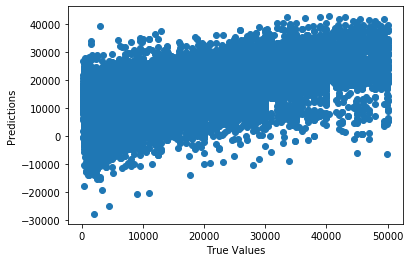

In [68]:
y_pred = lm.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")


In [69]:
print ("Score:", lm.score(X_test, y_test))

Score: 0.5632155216317261


In [70]:
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

Root Mean Squared Error:6343.728687068751


In [71]:
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Training:  6360 vs. Testing:  6343


### Feature Selection

In [72]:
corr_matrix = df_features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,year,odometer,new_tires,heated_seats,auto_headlight,power steering,leather,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_datsun,manufacturer_dodge,manufacturer_ferrari,manufacturer_fiat,manufacturer_ford,manufacturer_gmc,manufacturer_harley-davidson,manufacturer_honda,manufacturer_hyundai,manufacturer_infiniti,manufacturer_jaguar,manufacturer_jeep,manufacturer_kia,manufacturer_land rover,manufacturer_lexus,manufacturer_lincoln,manufacturer_mazda,manufacturer_mercedes-benz,manufacturer_mercury,manufacturer_mini,manufacturer_mitsubishi,manufacturer_morgan,manufacturer_nissan,manufacturer_pontiac,manufacturer_porche,manufacturer_ram,manufacturer_rover,manufacturer_saturn,manufacturer_subaru,manufacturer_tesla,manufacturer_toyota,manufacturer_volkswagen,manufacturer_volvo,condition_fair,condition_good,condition_salvage,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,transmission_manual,transmission_other,drive_fwd,drive_rwd,size_full-size,size_mid-size,size_sub-compact,type_bus,type_convertible,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
year,NaN,0.256565,0.036123,0.105427,0.104295,0.702086,0.119360,0.010685,0.004281,0.026251,0.015388,0.011796,0.019459,0.043632,0.002887,0.045966,0.012396,0.013928,0.016626,0.025254,0.011656,0.001580,0.015233,0.060647,0.014012,0.023592,0.022621,0.058334,0.003991,0.009403,0.019680,0.008976,0.016167,0.054658,0.013976,0.014366,0.005784,0.077215,0.085529,0.011296,0.046612,0.008160,0.021406,0.041688,0.013643,0.011204,0.007515,0.013311,0.035379,0.057593,0.039214,0.026172,0.025180,0.027556,0.050929,0.026555,0.146552,0.033372,0.052808,0.008430,0.263888,0.091607,0.137813,0.197643,0.085682,0.022793,0.007741,0.021648,0.110309,0.086654,0.048109,0.006448,0.041592,0.036853,0.028469,0.068520,0.014296,0.023372,0.019582,0.027568,0.029855,0.031500,0.096411,0.046140,0.030120,0.015224,0.028938,0.042814,0.074789,0.066728
odometer,NaN,NaN,0.047317,0.062010,0.084482,0.079610,0.043220,0.010136,0.008052,0.023910,0.031385,0.022380,0.003533,0.000582,0.002698,0.006146,0.011676,0.003208,0.037773,0.037041,0.037063,0.007789,0.038260,0.046716,0.004747,0.013716,0.038219,0.043993,0.001439,0.025586,0.006129,0.012759,0.017796,0.021626,0.025523,0.018298,0.001131,0.059233,0.029838,0.002720,0.020888,0.011243,0.029350,0.016618,0.019567,0.055689,0.040091,0.019437,0.023266,0.034139,0.016684,0.045457,0.098879,0.000341,0.036135,0.024239,0.010598,0.004152,0.074866,0.015335,0.018450,0.170329,0.082032,0.011802,0.127406,0.027301,0.012939,0.006789,0.056810,0.084530,0.053630,0.035848,0.000544,0.070016,0.021567,0.063137,0.081987,0.009846,0.001248,0.001264,0.021474,0.003889,0.047280,0.018573,0.019762,0.005397,0.017707,0.000254,0.001369,0.000902
new_tires,NaN,NaN,NaN,0.018874,0.024044,0.015418,0.017939,0.000406,0.000951,0.001236,0.004707,0.005182,0.002858,0.003990,0.002120,0.000099,0.000935,0.000393,0.000265,0.000998,0.006053,0.002338,0.005445,0.001657,0.003867,0.000219,0.000077,0.000829,0.002243,0.007243,0.001986,0.003449,0.012194,0.006693,0.000075,0.002429,0.000575,0.002946,0.005564,0.000759,0.015782,0.001425,0.003816,0.000437,0.002685,0.005706,0.005013,0.001691,0.050644,0.019097,0.000501,0.004563,0.014829,0.005951,0.028393,0.007784,0.004066,0.003202,0.005567,0.001700,0.005629,0.045730,0.008392,0.012072,0.037678,0.041046,0.005937,0.003856,0.003356,0.007382,0.002410,0.011928,0.000221,0.025628,0.012749,0.008256,0.001590,0.001397,0.007239,0.000818,0.007652,0.010713,0.006818,0.005975,0.001856,0.000806,0.001231,0.001524,0.004208,0.001088
heated_seat

In [73]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print(to_drop)

[]


In [83]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_features.values, i) for i in range(df_features.shape[1])]
vif["features"] = df_features.columns
vif.round(1)

,VIF Factor,features
0,58.8,year
1,4.7,odometer
2,1.1,new_tires
3,1.3,heated_seats
4,1.1,auto_headlight
...,...,...
85,1.0,paint_color_purple
86,1.2,paint_color_red
87,1.3,paint_color_silver
88,1.6,paint_color_white


### Using k best

In [74]:
selector = SelectKBest(f_regression, k = 20)
selector.fit(X_train, y_train)

selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [75]:
list(removed_columns)

['new_tires',
 'manufacturer_alfa-romeo',
 'manufacturer_aston-martin',
 'manufacturer_audi',
 'manufacturer_bmw',
 'manufacturer_buick',
 'manufacturer_cadillac',
 'manufacturer_chevrolet',
 'manufacturer_chrysler',
 'manufacturer_datsun',
 'manufacturer_dodge',
 'manufacturer_ferrari',
 'manufacturer_fiat',
 'manufacturer_ford',
 'manufacturer_harley-davidson',
 'manufacturer_hyundai',
 'manufacturer_infiniti',
 'manufacturer_jaguar',
 'manufacturer_jeep',
 'manufacturer_kia',
 'manufacturer_land rover',
 'manufacturer_lexus',
 'manufacturer_lincoln',
 'manufacturer_mazda',
 'manufacturer_mercedes-benz',
 'manufacturer_mercury',
 'manufacturer_mini',
 'manufacturer_mitsubishi',
 'manufacturer_morgan',
 'manufacturer_nissan',
 'manufacturer_pontiac',
 'manufacturer_porche',
 'manufacturer_rover',
 'manufacturer_saturn',
 'manufacturer_subaru',
 'manufacturer_tesla',
 'manufacturer_toyota',
 'manufacturer_volkswagen',
 'manufacturer_volvo',
 'condition_salvage',
 'fuel_electric',
 'fue

In [76]:
list(selected_columns)

['year',
 'odometer',
 'heated_seats',
 'auto_headlight',
 'power steering',
 'leather',
 'manufacturer_gmc',
 'manufacturer_honda',
 'manufacturer_ram',
 'condition_fair',
 'condition_good',
 'fuel_gas',
 'fuel_other',
 'transmission_other',
 'drive_fwd',
 'size_mid-size',
 'type_pickup',
 'type_sedan',
 'type_truck',
 'paint_color_white']

In [77]:
#instantiate a linear regression object
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest = lm_kbest.fit(X_train[selected_columns], y_train)

y_train_kbest = lm_kbest.predict(X_train[selected_columns])


trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))


print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = lm_kbest.predict(X_test[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)


print('Original: ', test_rmse, "vs. KBest: ", testK_rmse)

Training Root Mean Squared Error: 6683.319166760019
Testing Root Mean Squared Error: 6667.089869857531
Original:  6343.728687068751 vs. KBest:  6667.089869857531


#### RMSE with k best is worse than regular


### Trying Recursive feature elimination

In [78]:
ols = linear_model.LinearRegression()
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)


RFECV(cv=5,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [79]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]


In [80]:
list(removed_rfe)

[]

In [81]:
len(list(selected_rfe))

90

In [82]:
#instantiate a linear regression object
lm_rfe = LinearRegression()

#fit the linear regression to the data
lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_rfe = lm_rfe.predict(X_train[selected_rfe])


trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))


print('Training Root Mean Squared Error:' , trainRFE_rmse)

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])

testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print('Testing Root Mean Squared Error:' , testRFE_rmse)


print('Original: ', test_rmse, "vs. KBest: ", testK_rmse, "vs. RFE: ", testRFE_rmse)

Training Root Mean Squared Error: 6360.257300174636
Testing Root Mean Squared Error: 6343.728687068751
Original:  6343.728687068751 vs. KBest:  6667.089869857531 vs. RFE:  6343.728687068751
